In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## Dataset 및 activation 함수 변경
- Dataset을 MNIST에서 [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)으로 변경해줍니다.
- Activation 함수를 `nn.ReLU`에서 `nn.LeakyReLU`로 변경해줍니다.
- 학습 인자는 `n_epochs` = 50, `batch_size` = 256로 설정합니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

## CIFAR10의 입력 shape 확인
- CIFAR10은 MNIST와 다른 입력 shape을 가지고 있습니다.
- 입력 shape은 model을 선언할 때 중요하기 때문에 MNIST 실습 자료에서 사용한 방식과 똑같이 shape을 확인해주시면 됩니다.

In [3]:
print(trainset[0][0].shape)

torch.Size([3, 32, 32])


In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [6]:
from torch import nn

class Model1(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

## SGD와 Adam 성능 비교
- 먼저 [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)을 사용하여 학습하는 코드를 구현합니다.
- (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.

In [7]:
from torch.optim import SGD, Adam

# 모델 훈련 함수
def train_model(model, optimizer, trainloader, loss_fn, n_epochs=50, testloader=None):
  model = model.to('cuda')
  optimizer = optimizer(model.parameters(), lr=0.001)

  train_results, test_results = [], []

  for epoch in range(n_epochs):
        total_loss = 0.
        model.train()
        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_results.append(accuracy(model, trainloader))

        if testloader:
            test_results.append(accuracy(model, testloader))

        print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

  if testloader:
    return train_results, test_results
  else:
    return train_results

In [8]:
# 모델 정의
model = Model1(32 * 32 * 3, 1024)

# 손실 함수
loss_fn = nn.CrossEntropyLoss()

# SGD 훈련
train_sgd = train_model(model, SGD, trainloader, loss_fn, n_epochs=50)

# Adam 훈련
train_adam, test_adam = train_model(model, Adam, trainloader, loss_fn, n_epochs=50, testloader=testloader)

Epoch   1 | Loss: 450.56217193603516
Epoch   2 | Loss: 449.4869771003723
Epoch   3 | Loss: 448.4436070919037
Epoch   4 | Loss: 447.3966586589813
Epoch   5 | Loss: 446.2532856464386
Epoch   6 | Loss: 445.0722088813782
Epoch   7 | Loss: 443.88552713394165
Epoch   8 | Loss: 442.657931804657
Epoch   9 | Loss: 441.41377878189087
Epoch  10 | Loss: 440.0865681171417
Epoch  11 | Loss: 438.7975571155548
Epoch  12 | Loss: 437.4121754169464
Epoch  13 | Loss: 435.21101331710815
Epoch  14 | Loss: 432.42898893356323
Epoch  15 | Loss: 430.23198103904724
Epoch  16 | Loss: 428.0214099884033
Epoch  17 | Loss: 425.9317274093628
Epoch  18 | Loss: 423.7842402458191
Epoch  19 | Loss: 420.7932803630829
Epoch  20 | Loss: 417.90099453926086
Epoch  21 | Loss: 415.13089203834534
Epoch  22 | Loss: 412.50601267814636
Epoch  23 | Loss: 409.9364216327667
Epoch  24 | Loss: 407.47590470314026
Epoch  25 | Loss: 405.1346220970154
Epoch  26 | Loss: 402.85165905952454
Epoch  27 | Loss: 400.7132046222687
Epoch  28 | Loss: 

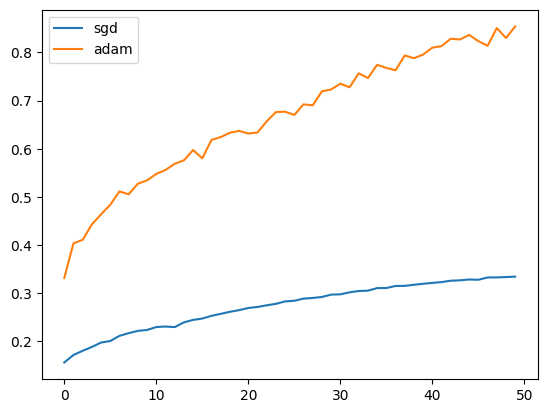

In [9]:
plot_acc(train_sgd, train_adam, 'sgd', 'adam')

## Leaky ReLU와 Sigmoid 성능 비교
- Activation 함수가 `nn.Sigmoid`인 class를 새로 정의합니다.
- (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.

In [11]:
class Model2(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [12]:
# 모델 정의
model = Model2(32 * 32 * 3, 1024)

# train_sigmoid 훈련
train_sigmoid = train_model(model, Adam, trainloader, loss_fn, n_epochs=50)

Epoch   1 | Loss: 410.42474913597107
Epoch   2 | Loss: 393.6189750432968
Epoch   3 | Loss: 387.0837401151657
Epoch   4 | Loss: 383.7214666604996
Epoch   5 | Loss: 381.1255030632019
Epoch   6 | Loss: 379.20686995983124
Epoch   7 | Loss: 377.4203414916992
Epoch   8 | Loss: 375.66504096984863
Epoch   9 | Loss: 374.25130474567413
Epoch  10 | Loss: 372.97972333431244
Epoch  11 | Loss: 372.16388404369354
Epoch  12 | Loss: 370.9137307405472
Epoch  13 | Loss: 370.226895570755
Epoch  14 | Loss: 369.1675480604172
Epoch  15 | Loss: 368.19019305706024
Epoch  16 | Loss: 367.5971620082855
Epoch  17 | Loss: 367.3331707715988
Epoch  18 | Loss: 366.1290593147278
Epoch  19 | Loss: 364.7071828842163
Epoch  20 | Loss: 364.3159919977188
Epoch  21 | Loss: 363.60319352149963
Epoch  22 | Loss: 363.5713995695114
Epoch  23 | Loss: 362.4897663593292
Epoch  24 | Loss: 361.4168838262558
Epoch  25 | Loss: 361.63932180404663
Epoch  26 | Loss: 361.7285565137863
Epoch  27 | Loss: 360.3762344121933
Epoch  28 | Loss: 36

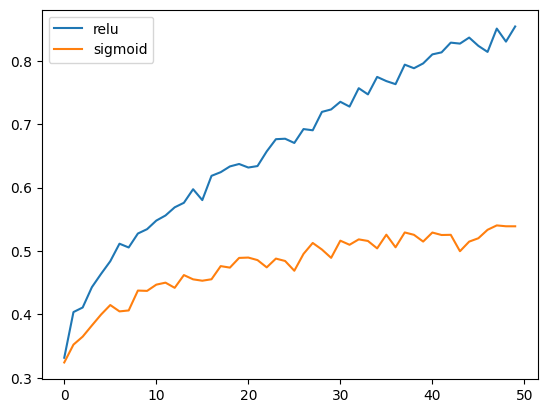

In [13]:
plot_acc(train_adam, train_sigmoid, 'relu', 'sigmoid')

## Dropout을 적용한 이후의 generalization error 확인
- PyTorch dropout을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다. Dropout 확률은 0.1로 설정합니다.
- 학습 코드에서 다음 부분들을 추가
  - model.train()을 for data in trainloader: 이전 줄에 둡니다.
  - trainloader와 testloader에 대한 정확도를 계산하는 코드를 다음과 같이 변경
    - ```python
      with torch.no_grad():
        model.eval()
        <기존 정확도 계산 코드>
    ```
    - (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교합니다.

In [14]:
# Dropout

class Model3(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.dropout(self.act(self.layer3(x)))

    return x

In [17]:
model = Model3(32 * 32 * 3, 1024)
model = model.to('cuda')

optimizer = Adam(model.parameters(), lr=0.001)

train_dropout = []
test_dropout = []

for epoch in range(50):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
    train_dropout.append(accuracy(model, trainloader))
    test_dropout.append(accuracy(model, testloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 438.46129989624023
Epoch   2 | Loss: 415.0366508960724
Epoch   3 | Loss: 406.90117263793945
Epoch   4 | Loss: 396.6285808086395
Epoch   5 | Loss: 387.0092487335205
Epoch   6 | Loss: 382.601185798645
Epoch   7 | Loss: 376.96961534023285
Epoch   8 | Loss: 372.56213319301605
Epoch   9 | Loss: 372.85860311985016
Epoch  10 | Loss: 365.3373519182205
Epoch  11 | Loss: 362.4467850923538
Epoch  12 | Loss: 359.4453947544098
Epoch  13 | Loss: 358.4589490890503
Epoch  14 | Loss: 355.59663021564484
Epoch  15 | Loss: 352.87095046043396
Epoch  16 | Loss: 350.82106697559357
Epoch  17 | Loss: 349.30367505550385
Epoch  18 | Loss: 345.4752354621887
Epoch  19 | Loss: 343.8152445554733
Epoch  20 | Loss: 342.321799993515
Epoch  21 | Loss: 340.5875531435013
Epoch  22 | Loss: 339.44458961486816
Epoch  23 | Loss: 337.85906541347504
Epoch  24 | Loss: 335.27935326099396
Epoch  25 | Loss: 334.41756987571716
Epoch  26 | Loss: 333.0415635108948
Epoch  27 | Loss: 332.0685119628906
Epoch  28 | Loss:

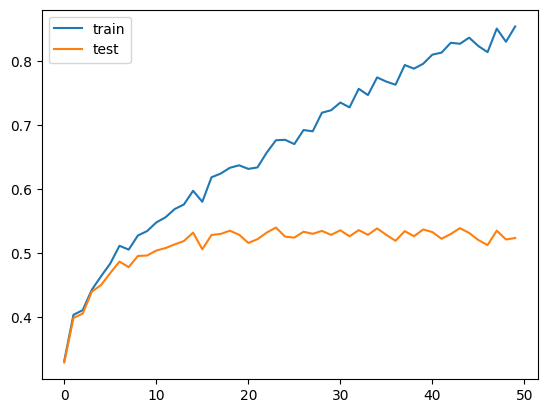

In [18]:
plot_acc(train_adam, test_adam)

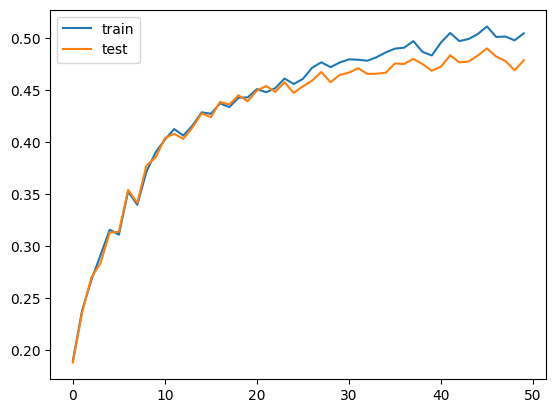

In [19]:
plot_acc(train_dropout, test_dropout)